# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 1C
+ S1C

#### Archives:
+ Transcription_licensed-DNA_ATP_LS.yama
+ Transcription_licensed-DNA_ATP_HS.yama
+ Transcription_licensed-DNA_ATPgS_LS.yama
+ Transcription_licensed-DNA_ATPgS_HS.yama
+ Transcription_licensed-DNA_T7T_ATP.yama
+ Transcription_licensed-DNA_T7T_ATPgS.yama

#### Additional data:
+ Mcm4_Integrations.csv

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_licensed-DNA_ATP_LS.yama',
                     'Transcription_licensed-DNA_ATP_HS.yama',
                     'Transcription_licensed-DNA_ATPgS_LS.yama',
                     'Transcription_licensed-DNA_ATPgS_HS.yama',
                     'Transcription_licensed-DNA_T7T_ATP.yama',
                     'Transcription_licensed-DNA_T7T_ATPgS.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_licensed-DNA_ATP_LS,1,245,ybbR-LD555-T7; ybbR-LD655-MCM,ATP,False,n/a,False,passed
Transcription_licensed-DNA_ATP_HS,1,330,ybbR-LD555-T7; ybbR-LD655-MCM,ATP,True,n/a,False,passed
Transcription_licensed-DNA_ATPgS_LS,1,283,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,False,n/a,False,passed
Transcription_licensed-DNA_ATPgS_HS,1,63,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,True,n/a,False,passed
Transcription_licensed-DNA_T7T_ATP,2,653,ybbR-LD555-T7; ybbR-LD655-MCM,ATP,False,n/a,True,passed
Transcription_licensed-DNA_T7T_ATPgS,2,482,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, initial_intensity, ), (MCM_1_, lifetime, ), (MCM_1_, number_pauses, ), (MCM_1_, start_site, ), (MCM_1_, stop_site, ), (MCM_2_, initial_intensity, ), (MCM_2_, lifetime, ), (MCM_2_, number_pauses, ), (MCM_2_, start_site, ), (MCM_2_, stop_site, ), (ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 25 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            elif re.match('MCM',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")         
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          MCM_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
tt6fhtfZG756vaP8naXmT8           53390.6    150.0           NaN      NaN   
8jCyrcDPJSf24W1YFSKGph           87420.6    149.0           1.0  385.151   
9sDdELLnQKWDxdxr1u9jxH           24604.9    150.0           NaN      NaN   
uRNaXRjwYD5oPgxJ3EGLox           61938.8    150.0           NaN      NaN   
wpHhv4pYN6AfEZKothLud           354843.9    150.0           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
tt6fhtfZG756vaP8naXmT8             NaN      NaN      NaN             NaN   
8jCyrcDPJSf24W1YFSKGph    10539.005815     True      NaN             NaN   
9sDdELLnQKWDxdxr1u9jxH             NaN      NaN      NaN             NaN   
uRNaXRjwYD5oPgxJ3EGLox             NaN      NaN      NaN             NaN   
wpHhv4pYN6AfEZKothLud              NaN      NaN      NaN             NaN   

molecule                                       ... label_ORC    label_T7  \
properties                         start_site  ...                         
properties_details     recovery                ...                         
tt6fhtfZG756vaP8naXmT8      NaN   4180.908073  ...       NaN  ybbR-LD555   
8jCyrcDPJSf24W1YFSKGph      NaN   5611.080259  ...       NaN  ybbR-LD555   
9sDdELLnQKWDxdxr1u9jxH      NaN   5113.158198  ...       NaN  ybbR-LD555   
uRNaXRjwYD5oPgxJ3EGLox      NaN  15235.802491  ...       NaN  ybbR-LD555   
wpHhv4pYN6AfEZKothLud       NaN  16292.670529  ...       NaN  ybbR-LD555   

molecule               nucleotide number_MCM number_ORC number_T7  \
properties                                                          
properties_details                                                  
tt6fhtfZG756vaP8naXmT8        ATP        1.0        NaN       0.0   
8jCyrcDPJSf24W1YFSKGph        ATP        1.0        NaN       1.0   
9sDdELLnQKWDxdxr1u9jxH        ATP        1.0        NaN       0.0   
uRNaXRjwYD5oPgxJ3EGLox        ATP        2.0        NaN       0.0   
wpHhv4pYN6AfEZKothLud         ATP        2.0        NaN       0.0   

molecule                                           tags velocity_MCM  \
properties                                                             
properties_details                                                     
tt6fhtfZG756vaP8naXmT8                         [accept]          NaN   
8jCyrcDPJSf24W1YFSKGph  [accept, coloc_T7_1_MCM_1_push]    50.891824   
9sDdELLnQKWDxdxr1u9jxH                         [accept]          NaN   
uRNaXRjwYD5oPgxJ3EGLox                         [accept]          NaN   
wpHhv4pYN6AfEZKothLud                          [accept]          NaN   

molecule               velocity_ORC velocity_T7  
properties                                       
properties_details                               
tt6fhtfZG756vaP8naXmT8          NaN         NaN  
8jCyrcDPJSf24W1YFSKGph          NaN   51.359712  
9sDdELLnQKWDxdxr1u9jxH          NaN         NaN  
uRNaXRjwYD5oPgxJ3EGLox          NaN         NaN  
wpHhv4pYN6AfEZKothLud           NaN         NaN  

[5 rows x 57 columns]

## Figures

### Figure 1C: DNA licensing efficiency (single-molecule assays)
*Note*: Need to filter if DnaMoleculeCount was valid, ignore others

In [14]:
df['condition'] = df['nucleotide'] + ' - ' + df['hs_wash'].apply(lambda wash: 'high salt' if wash else 'low salt')

In [15]:
df.head()

molecule                          MCM_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
tt6fhtfZG756vaP8naXmT8           53390.6    150.0           NaN      NaN   
8jCyrcDPJSf24W1YFSKGph           87420.6    149.0           1.0  385.151   
9sDdELLnQKWDxdxr1u9jxH           24604.9    150.0           NaN      NaN   
uRNaXRjwYD5oPgxJ3EGLox           61938.8    150.0           NaN      NaN   
wpHhv4pYN6AfEZKothLud           354843.9    150.0           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
tt6fhtfZG756vaP8naXmT8             NaN      NaN      NaN             NaN   
8jCyrcDPJSf24W1YFSKGph    10539.005815     True      NaN             NaN   
9sDdELLnQKWDxdxr1u9jxH             NaN      NaN      NaN             NaN   
uRNaXRjwYD5oPgxJ3EGLox             NaN      NaN      NaN             NaN   
wpHhv4pYN6AfEZKothLud              NaN      NaN      NaN             NaN   

molecule                                       ...    label_T7 nucleotide  \
properties                         start_site  ...                          
properties_details     recovery                ...                          
tt6fhtfZG756vaP8naXmT8      NaN   4180.908073  ...  ybbR-LD555        ATP   
8jCyrcDPJSf24W1YFSKGph      NaN   5611.080259  ...  ybbR-LD555        ATP   
9sDdELLnQKWDxdxr1u9jxH      NaN   5113.158198  ...  ybbR-LD555        ATP   
uRNaXRjwYD5oPgxJ3EGLox      NaN  15235.802491  ...  ybbR-LD555        ATP   
wpHhv4pYN6AfEZKothLud       NaN  16292.670529  ...  ybbR-LD555        ATP   

molecule               number_MCM number_ORC number_T7  \
properties                                               
properties_details                                       
tt6fhtfZG756vaP8naXmT8        1.0        NaN       0.0   
8jCyrcDPJSf24W1YFSKGph        1.0        NaN       1.0   
9sDdELLnQKWDxdxr1u9jxH        1.0        NaN       0.0   
uRNaXRjwYD5oPgxJ3EGLox        2.0        NaN       0.0   
wpHhv4pYN6AfEZKothLud         2.0        NaN       0.0   

molecule                                           tags velocity_MCM  \
properties                                                             
properties_details                                                     
tt6fhtfZG756vaP8naXmT8                         [accept]          NaN   
8jCyrcDPJSf24W1YFSKGph  [accept, coloc_T7_1_MCM_1_push]    50.891824   
9sDdELLnQKWDxdxr1u9jxH                         [accept]          NaN   
uRNaXRjwYD5oPgxJ3EGLox                         [accept]          NaN   
wpHhv4pYN6AfEZKothLud                          [accept]          NaN   

molecule               velocity_ORC velocity_T7       condition  
properties                                                       
properties_details                                               
tt6fhtfZG756vaP8naXmT8          NaN         NaN  ATP - low salt  
8jCyrcDPJSf24W1YFSKGph          NaN   51.359712  ATP - low salt  
9sDdELLnQKWDxdxr1u9jxH          NaN         NaN  ATP - low salt  
uRNaXRjwYD5oPgxJ3EGLox          NaN         NaN  ATP - low salt  
wpHhv4pYN6AfEZKothLud           NaN         NaN  ATP - low salt  

[5 rows x 58 columns]

In [16]:
#generate grouped dfs
df_groupby_cond_numMCM = df[df['dna_count_valid']].groupby(['condition','number_MCM']).describe()
df_groupby_cond_numMCM

molecule                                MCM_1_                              \
properties                   initial_intensity                               
properties_details                                                           
                                         count          mean           std   
condition         number_MCM                                                 
ATP - high salt   0.0                      0.0           NaN           NaN   
                  1.0                    313.0  38923.207668  20807.918239   
                  2.0                      9.0  30747.955556  19783.525642   
ATP - low salt    0.0                      0.0           NaN           NaN   
                  1.0                    863.0  57863.462804  41040.139217   
                  2.0                     18.0  62244.861111  75860.888760   
ATPgS - high salt 0.0                      0.0           NaN           NaN   
                  1.0                     16.0  14559.575000   6074.073434   
ATPgS - low salt  0.0                      0.0           NaN           NaN   
                  1.0                    597.0  19201.008208  18924.104390   
                  2.0                     18.0  21064.322222  10205.070498   

molecule                                                               \
properties                                                              
properties_details                                                      
                                  min        25%       50%        75%   
condition         number_MCM                                            
ATP - high salt   0.0             NaN        NaN       NaN        NaN   
                  1.0          8510.8  24466.800  32261.00  49589.000   
                  2.0         16386.5  22528.900  27459.10  29019.600   
ATP - low salt    0.0             NaN        NaN       NaN        NaN   
                  1.0          6912.0  34783.500  49840.40  71220.750   
                  2.0         16820.8  29673.450  43597.00  62561.300   
ATPgS - high salt 0.0             NaN        NaN       NaN        NaN   
                  1.0          7377.8  10690.800  12266.15  18272.550   
ATPgS - low salt  0.0             NaN        NaN       NaN        NaN   
                  1.0          4181.9  12670.800  15558.00  20433.400   
                  2.0          5514.3  14616.375  20486.15  23335.025   

molecule                                                     ... velocity_ORC  \
properties                             lifetime              ...                
properties_details                                           ...                
                                   max    count        mean  ...          75%   
condition         number_MCM                                 ...                
ATP - high salt   0.0              NaN      0.0         NaN  ...          NaN   
                  1.0         143545.8    313.0  137.578275  ...          NaN   
                  2.0          81811.2      9.0  141.333333  ...          NaN   
ATP - low salt    0.0              NaN      0.0         NaN  ...    57.636660   
                  1.0         478376.9    863.0  141.595597  ...    55.380640   
                  2.0         354843.9     18.0  145.388889  ...          NaN   
ATPgS - high salt 0.0              NaN      0.0         NaN  ...          NaN   
                  1.0          29610.1     16.0  135.125000  ...          NaN   
ATPgS - low salt  0.0              NaN      0.0         NaN  ...    28.103739   
                  1.0         268229.6    597.0  130.896147  ...    28.620516   
                  2.0          49890.9     18.0  147.611111  ...    28.323785   

molecule                                velocity_T7                       \
properties                                                                 
properties_details                                                         
                                    max       count      

In [17]:
# estimate standard error by bootstrapping

In [18]:
_plot_df = pd.DataFrame(columns=['condition','# of MCMs'])
protein = 'MCM'

for cond in df['condition'].unique():
    for num_mcm in range(1,int(df[df['dna_count_valid']]['number_MCM'].max())+1):
        # figure out total dna_number
        dna_number = 0
        for archive in DnaMoleculeArchive.instances:
            if (cond == (archive.nucleotide + ' - ' + ('high salt' if archive.highsalt_wash else 'low salt')) 
                and archive.dna_count_valid):
                dna_number += archive.dna_molecule_count
        
        _temp_df = pd.DataFrame(data=([dna_number]))
        _temp_df.columns = ['dna_number']
        _temp_df['condition'] = cond
        _temp_df['# of MCMs'] = num_mcm
        
        #if MCM number available calculate probability
        try:
            #set to value divided by total value
            probability = df_groupby_cond_numMCM.loc[(cond,float(num_mcm))][('number_MCM','','','count')]/\
             dna_number
        #if MCM number not available set probability to 0 (KeyError)
        except KeyError:
            probability = 0
        _temp_df['probability'] = probability
        
        # bootstrapping
        # generate list with #1 * probability and #0*(1-probability)*dna_number
        bootstrap_data = ([0 for _ in range(int((1-probability)*dna_number))] +
                          [1 for _ in range(int(probability*dna_number))])
        
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        _temp_df['bs_mean'] = np.mean(bootstrap_means)
        _temp_df['standard_error'] = np.std(bootstrap_means)
        _temp_df['68_ci_lower'], _temp_df['68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
        _temp_df['95_ci_lower'], _temp_df['95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
    
        _plot_df = pd.concat([_plot_df,_temp_df])
        _plot_df = _plot_df.convert_dtypes()
        _plot_df.reset_index(drop=True,inplace=True)

_plot_df

,condition,# of MCMs,dna_number,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,ATP - low salt,1,942,0.916136,0.917108,0.009019,0.908608,0.925611,0.899044,0.934113
1,ATP - low salt,2,942,0.019108,0.019078,0.004443,0.014862,0.023355,0.010616,0.028662
2,ATP - high salt,1,359,0.871866,0.874416,0.017499,0.857542,0.891061,0.837989,0.907821
3,ATP - high salt,2,359,0.025070,0.025023,0.008232,0.016713,0.033426,0.011142,0.041783
4,ATPgS - low salt,1,1170,0.511111,0.511016,0.014598,0.496581,0.525641,0.482051,0.539316
5,ATPgS - low salt,2,1170,0.015385,0.015347,0.003616,0.011966,0.018803,0.008547,0.023077
6,ATPgS - high salt,1,372,0.043011,0.042898,0.010548,0.032258,0.053763,0.024194,0.064516
7,ATPgS - high salt,2,372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


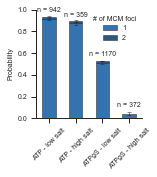

In [19]:
fig,axes = plt.subplots()
protein = 'MCM'
_plot_df.groupby(['condition','# of MCMs'])['probability'].sum().unstack().loc[
    ['ATP - low salt','ATP - high salt','ATPgS - low salt','ATPgS - high salt']].plot(kind='bar',width=0.5, figsize=(1.91,2),stacked=True, ax=axes,lw=0.5, edgecolor='.15',
                                                                                       color=[sns.desaturate(palettes['MCM'][1],0.75),sns.desaturate(palettes['MCM'][3],0.75)],
                                                                                       error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                                                                                       yerr=_plot_df.groupby(['condition','# of MCMs'])['standard_error'].sum().unstack())
axes.set_ylim(0,1)
axes.set_xlabel(None)
axes.set_ylabel('Probability')
axes.legend(title='# of MCM foci',frameon=False,loc=1)
for item in axes.get_xticklabels():
    item.set_rotation(45)

labels = list(_plot_df['dna_number'][::2])

#calculate y offset to label bars on top
dy = list(_plot_df['probability'][::2])

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    height = dy[counter]
    axes.text(rect.get_x() + rect.get_width()/2, height+0.05, s=f"n = {int(label)}", ha='center', va='bottom')
    counter+=1

sns.despine()


plt.savefig(dir_out+'1C_SM_licensing_efficiency.svg',transparent=True)

### Figure S1C: DNA licensing efficiency (ensemble assays)

In [20]:
# set directory
df2 = pd.read_csv('/Volumes/pool-duderstadt/Matthias/Manuscript/Additional_data/Mcm4_Integrations.csv',
                sep=';',header=[0])

In [21]:
df2.head()

,intensity,nucleotide,Mcm6,hs_wash,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,6767.569,ATP,wt,False,NaN,NaN,NaN,NaN,NaN
1,5663.326,ATP,wt,False,NaN,NaN,NaN,NaN,NaN
2,7640.539,ATP,wt,False,NaN,NaN,NaN,NaN,NaN
3,6326.296,ATP,wt,False,NaN,NaN,NaN,NaN,NaN
4,3522.548,ATP,wt,True,NaN,NaN,NaN,NaN,NaN


In [22]:
# remove nan rows/cols
df2.dropna(axis=0,how='all',inplace=True)
df2.dropna(axis=1,how='all',inplace=True)
df2['condition'] = df2['nucleotide'] +'_'+ df2['Mcm6'] + '_' + df2['hs_wash'].apply(str)
df2.head()

,intensity,nucleotide,Mcm6,hs_wash,condition
0,6767.569,ATP,wt,False,ATP_wt_False
1,5663.326,ATP,wt,False,ATP_wt_False
2,7640.539,ATP,wt,False,ATP_wt_False
3,6326.296,ATP,wt,False,ATP_wt_False
4,3522.548,ATP,wt,True,ATP_wt_True


In [23]:
df2_grouped = df2.groupby('condition').describe()['intensity']

In [24]:
# mean value to plot
df2_grouped['mean']

condition
ATP_wt_False              6599.43250
ATP_wt_True               3911.82075
ATP_ybbR-LD655_False      6817.40750
ATP_ybbR-LD655_True       4618.69725
ATPgS_wt_False            5088.11850
ATPgS_wt_True              775.43100
ATPgS_ybbR-LD655_False    4763.43650
ATPgS_ybbR-LD655_True      503.06650
Name: mean, dtype: float64

In [25]:
# sem to plot
df2_grouped['std']/df2_grouped['count'].apply(np.sqrt)

condition
ATP_wt_False              414.635538
ATP_wt_True               493.484949
ATP_ybbR-LD655_False      686.651605
ATP_ybbR-LD655_True       826.372239
ATPgS_wt_False            386.035500
ATPgS_wt_True               4.025000
ATPgS_ybbR-LD655_False     28.939500
ATPgS_ybbR-LD655_True       0.439500
dtype: float64

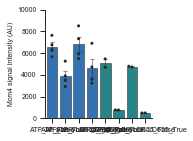

In [26]:
protein = 'MCM'
fig,axes = plt.subplots(figsize=(1.91,2))
axes.bar(x=df2_grouped['mean'].index, height= df2_grouped['mean'], yerr=df2_grouped['std']/df2_grouped['count'].apply(np.sqrt), 
         edgecolor='.15', lw=0.5, align='center', error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
         color=[(sns.desaturate(palettes['MCM'][1],0.75)) for _ in range(4)] +
                [(sns.desaturate(palettes['OCCM'][1],0.75)) for _ in range(4)])

sns.swarmplot(x='condition',y='intensity',data=df2, color='.15', ax=axes, size=3)
axes.set_ylim(0,10000)
axes.set_xlabel(None)
axes.set_ylabel('Mcm4 signal intensity (AU)')
sns.despine()

#plt.tight_layout()

plt.savefig(dir_out+'S1C_Ensemble_licensing_efficiency.svg',transparent=True)